# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Section 8: Operationalizing Models


**Harvard University**<br/>
**Spring 2021**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, and Chris Tanner <br/>
**Authors**: Shivas Jayaram 


<hr style="height:2pt">

## Learning Objectives

By the end of this notebook, you should be able to:
* Train an end to end image classification model
* Understand various CNN model architecturea and see which one works the best
* Save the best model so we can use it in our app

<a id="contents"></a>

## Notebook Contents
- **Dataset**
    - Download 
    - Load Data
    - View Images
    - Split Data
- **Build Data Pipelines**
    - Create TF Datasets
- **Image Classification Models**
    - Small CNN Network
    - Medium CNN Network
    - Large CNN Network
    - MobileNet - Transfer Learning
    - MobileNet - Transfer Learning (From TFHub)
- **Compare all Models**
    - Find Best Model
    - Predict using best model

## **Setup Notebook**

**Imports**

In [1]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# Tensorflow Hub
import tensorflow_hub as hub

# sklearn
from sklearn.model_selection import train_test_split

**Verify Setup**

In [2]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.4.1
keras version 2.4.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


**Utils**

Here we define some helper functions that would be used in loading data, saving models and evaluating models.

In [3]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)
  
  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

def save_model(model, path="models",model_name="model01"):

  # Ensure path exists
  if not os.path.exists(path):
      os.mkdir(path)

  # Save the enitire model (structure + weights)
  model.save(os.path.join(path,model_name+".hdf5"))

  # Save only the weights
  model.save_weights(os.path.join(path,model_name+".h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(path,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(path="models",model_name="model01"):
  model_size = os.stat(os.path.join(path,model_name+".hdf5")).st_size
  return model_size

def evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join("models",model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join("models",model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## **Dataset**

The dataset consists of images of mushrooms downloaded from Google Images. There are three types of mushrooms: 'oyster', 'crimini', 'amanita  

### **Download**

Download the datasets to colab.

In [4]:
start_time = time.time()
download_file("https://storage.googleapis.com/cs109b/datasets/mushrooms.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 0.21485764582951863


### **Load Data**

* Read-in data as lists.
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

In [5]:
base_path = os.path.join("datasets","mushrooms")
label_names = os.listdir(base_path)
print("Labels:", label_names)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path,label))
  data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

print("Full size of the dataset:",len(data_list))
print(data_list[:5])

# Build data x, y
data_x = [x[1] for x in data_list]
data_y = [x[0] for x in data_list]

print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

Labels: ['crimini', 'amanita', 'oyster']
Full size of the dataset: 1643
[('crimini', 'datasets/mushrooms/crimini/232.jpg'), ('crimini', 'datasets/mushrooms/crimini/118.jpg'), ('crimini', 'datasets/mushrooms/crimini/415.jpg'), ('crimini', 'datasets/mushrooms/crimini/95.jpg'), ('crimini', 'datasets/mushrooms/crimini/370.jpg')]
data_x: ['datasets/mushrooms/crimini/232.jpg', 'datasets/mushrooms/crimini/118.jpg', 'datasets/mushrooms/crimini/415.jpg', 'datasets/mushrooms/crimini/95.jpg', 'datasets/mushrooms/crimini/370.jpg']
data_y: ['crimini', 'crimini', 'crimini', 'crimini', 'crimini']


### **View Images**

Let's take a look at the data.

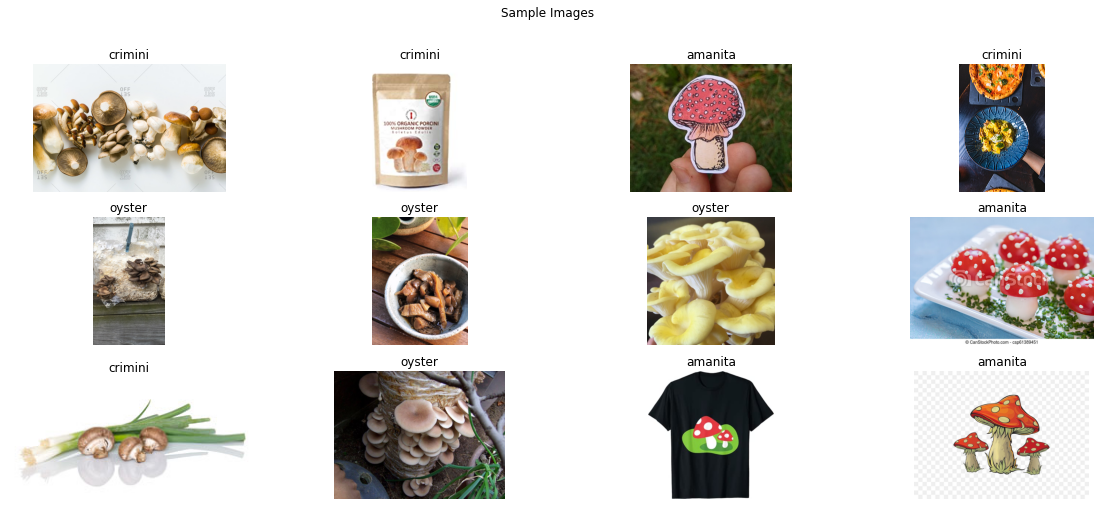

In [6]:
# View some images

# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

### **Split Data** 
We split data into train, validation, and test by randomly selecting 10% as the test set and 20% as the validation set.

In [7]:
test_percent = 0.10
validation_percent = 0.2

# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x, data_y, test_size=test_percent)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=test_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_x count:",len(test_x))

train_x count: 1330
validate_x count: 148
test_x count: 165


## **Build Data Pipelines**

### **Create TF Datasets**

In [8]:
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
train_shuffle_buffer_size= len(train_x)
validation_shuffle_buffer_size= len(validate_x)

# Load Image
def load_image(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height,image_width])
  return image, label

# Normalize pixels
def normalize(image, label):
  image = image/255
  #image = keras.applications.mobilenet.preprocess_input(image)
  return image, label

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]
test_processed_y = [label2index[label] for label in test_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')
test_processed_y = to_categorical(test_processed_y, num_classes=num_classes, dtype='float32')

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))
test_data = tf.data.Dataset.from_tensor_slices((test_x, test_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.map(load_image, num_parallel_calls=AUTOTUNE)
train_data = train_data.map(normalize, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)

##################
# Validation data
##################
# Apply all data processing logic
validation_data = validation_data.map(load_image, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(normalize, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)

############
# Test data
############
# Apply all data processing logic
test_data = test_data.map(load_image, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(normalize, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size)

print("train_data",train_data)
print("validation_data",validation_data)
print("test_data",test_data)

train_data <BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
validation_data <BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>
test_data <BatchDataset shapes: ((None, 224, 224, 3), (None, 3)), types: (tf.float32, tf.float32)>


## **Image Classificaton Models**

### **Small CNN Network**

In [9]:
# Build Model
def build_small_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='small_model')

  return model

### **Train**

Model: "small_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       

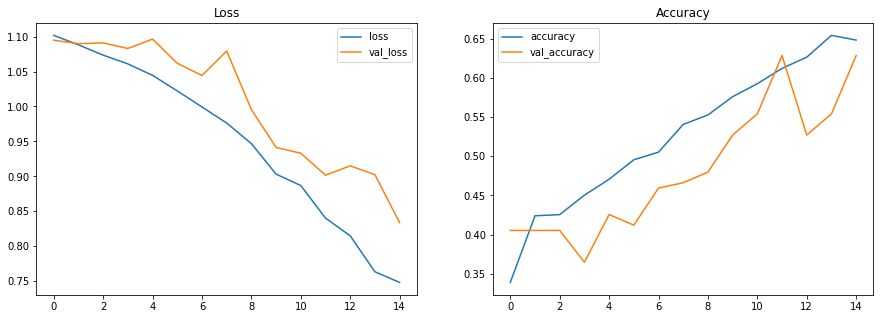

6/6 [==============================] - 2s 226ms/step - loss: 0.9186 - accuracy: 0.6061
[0.9186182022094727, 0.6060606241226196]


In [11]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 15

# Free up memory
K.clear_session()

# Build the model
model = build_small_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(lr=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **Medium CNN Network**

In [12]:
# Build Model
def build_medium_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='medium_model')

  return model

### **Train**

Model: "medium_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)      

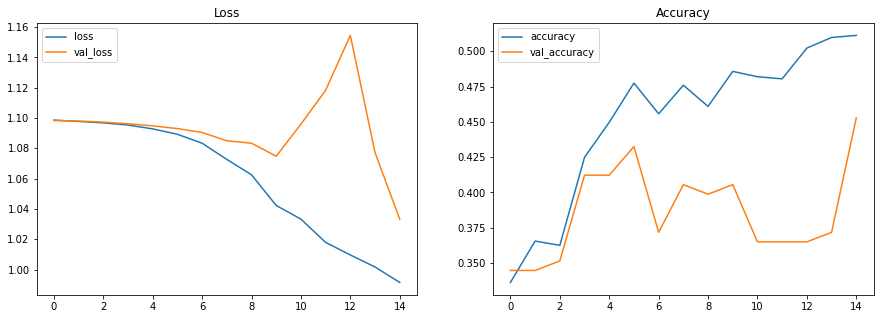

6/6 [==============================] - 2s 289ms/step - loss: 1.0291 - accuracy: 0.4545
[1.0291485786437988, 0.4545454680919647]


In [13]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 15

# Free up memory
K.clear_session()

# Build the model
model = build_medium_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(lr=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **Large CNN Network**

In [14]:
# Build Model
def build_large_model(image_height, image_width, num_channels, num_classes):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)
  
  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=512, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=512, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name='large_model')

  return model

### **Train**

Model: "large_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       

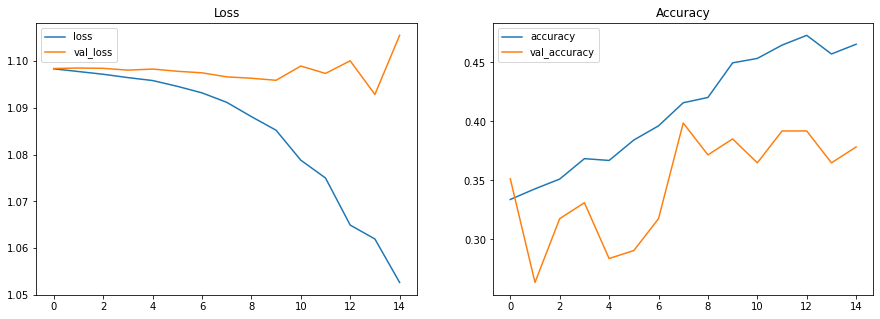

6/6 [==============================] - 2s 232ms/step - loss: 1.0782 - accuracy: 0.4424
[1.0781968832015991, 0.4424242377281189]


In [15]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 15

# Free up memory
K.clear_session()

# Build the model
model = build_large_model(image_height, image_width, num_channels, num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(lr=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **MobileNet - Transfer Learning**

In [16]:
# Build Model
def build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Load a pretrained model from keras.applications
  tranfer_model_base = keras.applications.MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)

  # Freeze the mobileNet model layers
  tranfer_model_base.trainable = train_base

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        tranfer_model_base,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(units=128, activation='relu',
                               kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                               bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                                  bias_regularizer=keras.regularizers.l1(bias_weight))
  ],name='mobilenetv2_train_base_'+str(train_base))

  return model

### **Train - Freeze base**

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_train_base_False"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,422,339
Trainable params: 164,355
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
42/42 [==============================] - 17s 87ms/step - loss: 108.2162 - accuracy: 0.4380 - val_loss: 105.9582 - val_accuracy: 0.5743
Epoch 

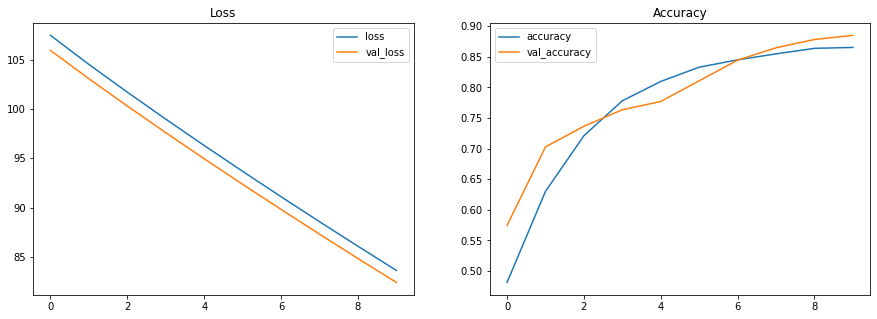

6/6 [==============================] - 2s 250ms/step - loss: 82.3901 - accuracy: 0.8606
[82.39008331298828, 0.8606060743331909]


In [17]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = False)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(lr=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **Train - UnFreeze base (Finetuning)**

Model: "mobilenetv2_train_base_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,422,339
Trainable params: 2,388,227
Non-trainable params: 34,112
_________________________________________________________________
None
Epoch 1/10
42/42 [==============================] - 23s 213ms/step - loss: 108.1351 - accuracy: 0.4148 - val_loss: 105.6917 - val_accuracy: 0.6689
Epoch 2/10
42/42 [==============================] - 18s 186ms/step - l

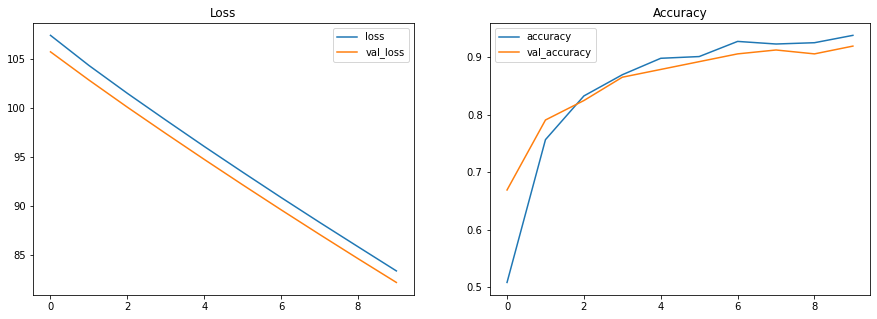

6/6 [==============================] - 2s 224ms/step - loss: 82.2454 - accuracy: 0.8545
[82.24535369873047, 0.8545454740524292]


In [18]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, train_base = True)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(lr=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **MobileNet - Transfer Learning (From TFHub)**

In [19]:
# Build Model
def build_model_tfhub(image_height, image_width, num_channels, num_classes, train_base = False):

  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels

  # Handle to pretrained model
  handle = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

  # Regularize using L1
  kernel_weight = 0.02
  bias_weight = 0.02

  model = Sequential([
        keras.layers.InputLayer(input_shape=input_shape),
        hub.KerasLayer(handle, trainable=train_base),
        keras.layers.Dense(units=64, activation='relu',
                               kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                               bias_regularizer=keras.regularizers.l1(bias_weight)),
        keras.layers.Dense(units=num_classes, activation='softmax',
                                  kernel_regularizer=keras.regularizers.l1(kernel_weight), 
                                  bias_regularizer=keras.regularizers.l1(bias_weight))
  ],name='tfhub_mobilenetv2_train_base_'+str(train_base))

  return model

### **Train - Freeze base**

Model: "tfhub_mobilenetv2_train_base_False"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 82,179
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10
42/42 [==============================] - 17s 70ms/step - loss: 56.2018 - accuracy: 0.3140 - val_loss: 54.9784 - val_accuracy: 0.4932
Epoch 2/10
42/42 [==============================] - 13s 55ms/step - loss: 54.6278 - accuracy: 0.5130 - val_loss: 53.4922 - val_accuracy: 0.6149
Epoch 3/10
42/42 [==============================] - 12

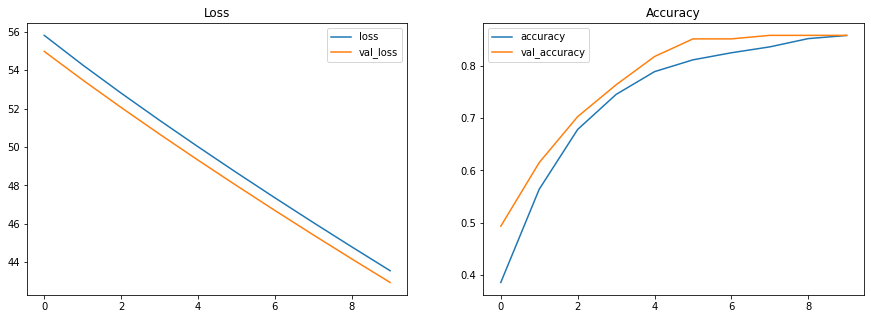

6/6 [==============================] - 2s 235ms/step - loss: 42.9440 - accuracy: 0.8424
[42.944034576416016, 0.842424213886261]


In [20]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_model_tfhub(image_height, image_width, num_channels, num_classes, train_base = False)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(lr=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **Train - UnFreeze base (Finetuning)**

Model: "tfhub_mobilenetv2_train_base_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 2,306,051
Non-trainable params: 34,112
_________________________________________________________________
None
Epoch 1/10
42/42 [==============================] - 25s 211ms/step - loss: 56.0982 - accuracy: 0.4868 - val_loss: 54.6713 - val_accuracy: 0.7838
Epoch 2/10
42/42 [==============================] - 18s 193ms/step - loss: 54.3048 - accuracy: 0.7884 - val_loss: 53.1732 - val_accuracy: 0.8176
Epoch 3/10
42/42 [==============================] - 1

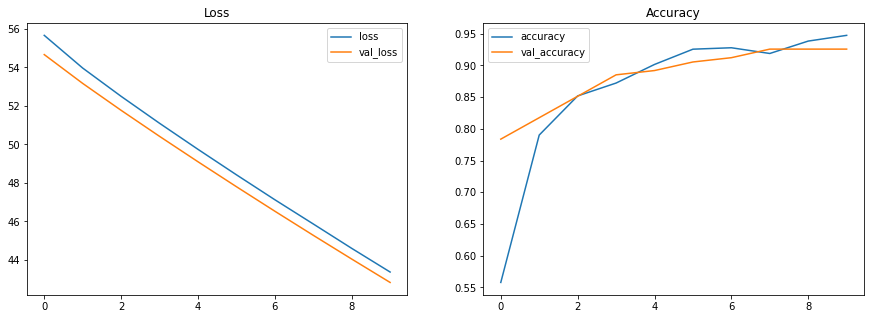

6/6 [==============================] - 2s 228ms/step - loss: 42.7994 - accuracy: 0.9091
[42.7994499206543, 0.9090909361839294]


In [21]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_model_tfhub(image_height, image_width, num_channels, num_classes, train_base = True)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = keras.optimizers.SGD(lr=learning_rate)

# Loss
loss = keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

## **Compare all Models**

In [22]:
models_store_path = "models"

models_metrics_list = glob(models_store_path+"/*_model_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace("models/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,batch_size,epochs,optimizer,name
0,"2,306,051",3.18 mins,42.80,90.91%,10 MB,0.001,32,10,SGD,tfhub_mobilenetv2_train_base_True
1,"164,355",2.25 mins,82.39,86.06%,10 MB,0.001,32,10,SGD,mobilenetv2_train_base_False
5,"2,388,227",3.09 mins,82.25,85.45%,10 MB,0.001,32,10,SGD,mobilenetv2_train_base_True
3,"82,179",2.17 mins,42.94,84.24%,10 MB,0.001,32,10,SGD,tfhub_mobilenetv2_train_base_False
2,"25,950,531",4.16 mins,0.92,60.61%,104 MB,0.010,32,15,SGD,small_model
6,"11,112,323",4.77 mins,1.03,45.45%,45 MB,0.010,32,15,SGD,medium_model
4,"22,514,755",4.71 mins,1.08,44.24%,90 MB,0.010,32,15,SGD,large_model


#### **Find Best Model**

In [25]:
best_model = 'models/'+view_metrics.iloc[0]["name"]+".hdf5"
print(best_model)

models/tfhub_mobilenetv2_train_base_True.hdf5


In [24]:
# To download the best model
# from google.colab import files
# files.download('models/'+view_metrics.iloc[0]["name"]+".hdf5") 

### **Predict using the best model**

In [28]:
# Load a model from disk
prediction_model = tf.keras.models.load_model(best_model, custom_objects={'KerasLayer':hub.KerasLayer})
#prediction_model = tf.keras.models.load_model(best_model)
prediction_model.summary()

Model: "tfhub_mobilenetv2_train_base_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 2,340,163
Trainable params: 2,306,051
Non-trainable params: 34,112
_________________________________________________________________


predictions.shape: (12, 3)
[0.9342768  0.0251122  0.04061099] 0


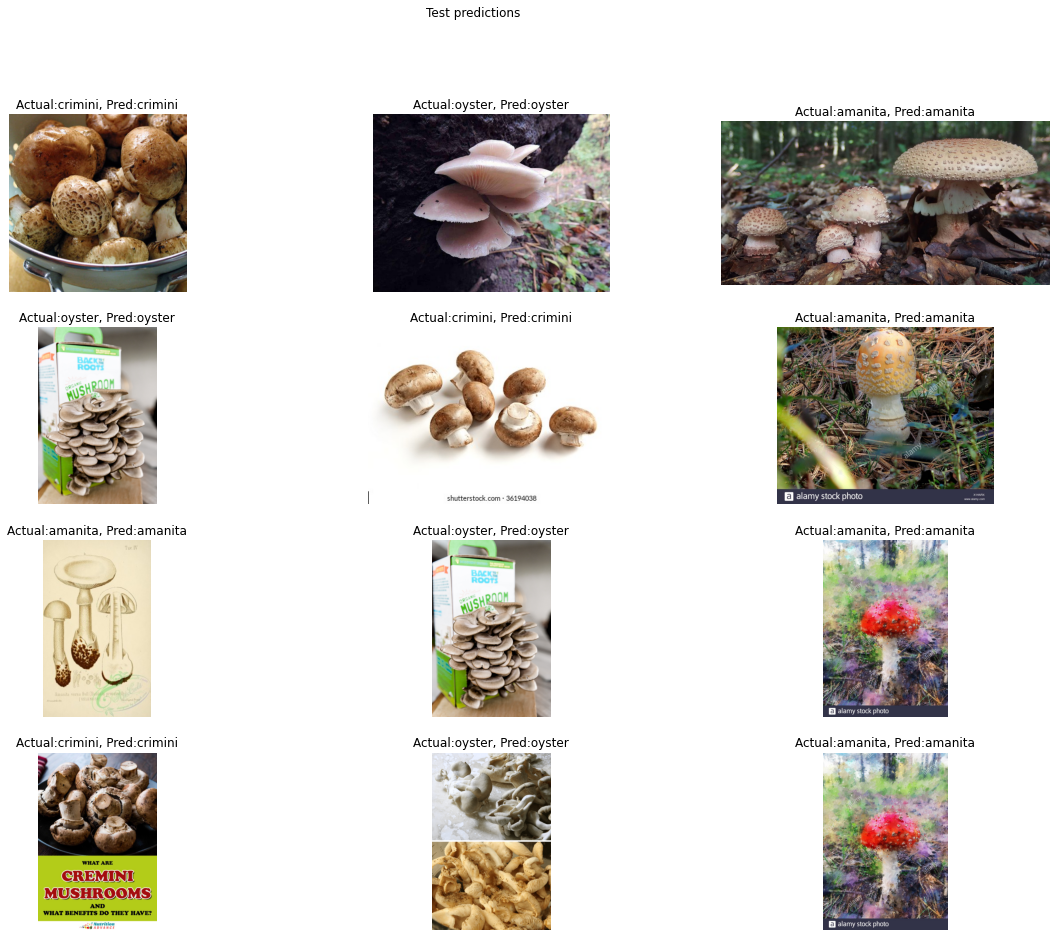

In [29]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(test_x)-1, size=12)
image_width = 224
image_height = 224
num_channels = 3

# Prepare the data
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height, image_width])

  image = keras.applications.mobilenet.preprocess_input(image)

  return image

prediction_image_paths = [test_x[img_idx] for img_idx in image_samples]
# Prepare the data for prediction
prediction_data = tf.data.Dataset.from_tensor_slices((prediction_image_paths))
prediction_data = prediction_data.map(preprocess_image, num_parallel_calls=AUTOTUNE)
prediction_data = prediction_data.batch(len(prediction_image_paths))

# Make prediction
predictions = prediction_model.predict(prediction_data)
print("predictions.shape:",predictions.shape)
print(predictions[0],predictions[0].argmax())

fig = plt.figure(figsize=(20,15))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(4,3,i+1)
    
    # Read image
    image = cv2.imread(test_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    # Actual label vs prediction
    prediction_label = index2label[predictions[i].argmax()]
    axs.set_title("Actual:"+test_y[img_idx]+", Pred:"+prediction_label)


    plt.axis('off')

plt.suptitle("Test predictions")
plt.show()